Son un algoritmo que puede hacer clasificación y regresión hasta salidas multiples.

## Entrenando y visualizndo un arbol de decisión

Vamos a construir un modelo para entender como funciona

In [1]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris(as_frame = True)
X = iris.data[['petal length (cm)', 'petal width (cm)']].values
y = iris.target

tree_clf = DecisionTreeClassifier(max_depth = 2, random_state = 42)
tree_clf.fit(X, y)

DecisionTreeClassifier(max_depth=2, random_state=42)

Ahora se visualiza usando `export_graphviz()`

In [2]:
from sklearn.tree import export_graphviz

export_graphviz(
    tree_clf,
    out_file = 'iris_tree.dot',
    feature_names = ['petal length (cm)', 'petal width (cm)'],
    class_names = iris.target_names,
    rounded = True,
    filled = True
)

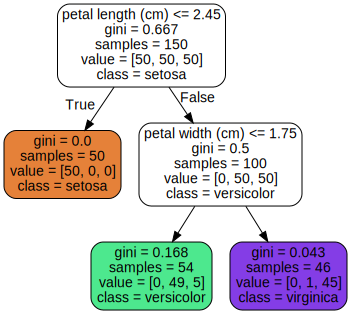

In [3]:
from graphviz import Source

Source.from_file('iris_tree.dot')

## Haciendo predicciones 

Por ejemplo, se quiere clasificar una flor basado en sus pétalos, empiezas en el primer nodo, este nodo pregunta si el tamaño del pétalo es menos de 2.45, si esto es verdad se continúa al nodo de la izquierda, este es un nodo hoja, ya que no tiene más decisiones abajo, este nodo nos dice que la clase predecida es setosa.

Una de las caracteristicas de los árboles de decisión es que no necesitan transformaciones, ni siquiera necesitan escalar las variables. 

Un nodo cuenta para cuantas observaciones aplica, por ejemplo, 100 observaciones tiene longitud de petalo mas de 2.45 (profundidad 1, derecha), de esos 100, 54 tienen ancho de petalo menor a 1.75 (profundida 2, izquierda). El nodo también te dice cuantas clases hay en él, por ejemplo el nodo morado tiene 0 setosa, 1 versicolor y 45 virginica.

La `impureza de Gini`, un nodo es puro (gini = 0) is todas las observaciones que tengan pertenecen a la misma clase. Por ejemplo el nodo naranja es puro, solo tienen observaciones de la clase setosa, el nodo verde tiene un impureza de gini igual a $1 - (0/54)^2 - (49/54)^2 - (5/54)^2 \approx 0.168$.

$$
G_i = 1 - \sum_{k=1}^n p_i,k^2
$$

Scikit usa el algoritmo `CART`, produce arboles binarios, otros algoritmos como `ID3` pueden producir arboles con nodos de más de dos hijos.

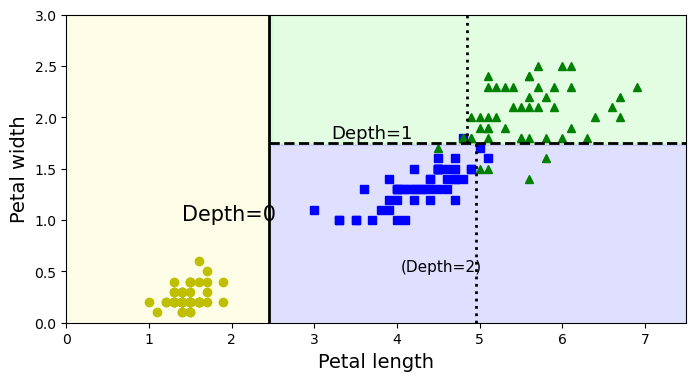

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], iris=True, legend=False, plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if not iris:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris virginica")
        plt.axis(axes)
    if iris:
        plt.xlabel("Petal length", fontsize=14)
        plt.ylabel("Petal width", fontsize=14)
    else:
        plt.xlabel(r"$x_1$", fontsize=18)
        plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        plt.legend(loc="lower right", fontsize=14)

plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf, X, y)
plt.plot([2.45, 2.45], [0, 3], "k-", linewidth=2)
plt.plot([2.45, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.plot([4.95, 4.95], [0, 1.75], "k:", linewidth=2)
plt.plot([4.85, 4.85], [1.75, 3], "k:", linewidth=2)
plt.text(1.40, 1.0, "Depth=0", fontsize=15)
plt.text(3.2, 1.80, "Depth=1", fontsize=13)
plt.text(4.05, 0.5, "(Depth=2)", fontsize=11)


plt.show()

In [5]:
help(tree_clf.tree_)

Help on Tree object:

class Tree(builtins.object)
 |  Array-based representation of a binary decision tree.
 |  
 |  The binary tree is represented as a number of parallel arrays. The i-th
 |  element of each array holds information about the node `i`. Node 0 is the
 |  tree's root. You can find a detailed description of all arrays in
 |  `_tree.pxd`. NOTE: Some of the arrays only apply to either leaves or split
 |  nodes, resp. In this case the values of nodes of the other type are
 |  arbitrary!
 |  
 |  Attributes
 |  ----------
 |  node_count : int
 |      The number of nodes (internal nodes + leaves) in the tree.
 |  
 |  capacity : int
 |      The current capacity (i.e., size) of the arrays, which is at least as
 |      great as `node_count`.
 |  
 |  max_depth : int
 |      The depth of the tree, i.e. the maximum depth of its leaves.
 |  
 |  children_left : array of int, shape [node_count]
 |      children_left[i] holds the node id of the left child of node i.
 |      For leave

Estos modelos de árboles de decisión se consideran modelos de caja blanca, son intuitivos y las decisiones son faciles de interpretar, modelos como Random forest y redes nueronales se conocen como modelo de caja negra, hace muy buenas predicciones y se pueden revisar los calculos hechos para hacer estas predicciones pero son dificiles de explicar en terminos sencillos, el area de `machine learning interpretable` busca crear sistemas de machine learning que pueda explicar sus decisiones en forma que los humanos entiendan.

## Estimar las probabilidades de la clase

Este modelo también puede estimar la probabilidad de que una observación pertenezca a una clase en particular k, primero va al nodo hoja para esta observación, luego devuelve el radio de observaciones de clase k en ese nodo. Por ejemplo se tiene una hoja con longitud 5 cm y ancho 1.5, el nodo hoja correspondiente es en la profundida 2 a la izquierda, las probabilidades serían: 0% para Setosa - (0/54), 90.7% para versicolor (49/54) y 9.3% para Virginica (5/54) 

In [6]:
tree_clf.predict_proba([[5, 1.5]]).round(3)

array([[0.   , 0.907, 0.093]])

In [7]:
tree_clf.predict([[5, 1.5]])

array([1])

## El algoritmo CART

sickit usa el algoritmo *Classification and Regression Tree (CART)* para entrenar arboles de decisión, primero divide el conjunto de entrenamiento en dos grupos usando una variables k y un limite $t_k$, para escogerlos busca el par ($k, t_j$) que produzca el subconjunto más puro, obtenemos la siguiente función de costo:

$$
J(k, t_k) = \frac{m_{left}}{m}G_{left}+\frac{m_{right}}{m}G_{right}
$$

donde G mide la impureza en el subconjunto y m es el numero de instancias en el conjunto.

Una vez el algoritmo CART haya dividido el grupo en dos subgrupos, repite el proceso usando la misma lógica hasta encontrar su máxima profundidad o no pueda encontrar una división que reduzca la impureza.

Este algoritmo no checkea que la división que hace vaya a generar la impureza más pequeña en las otras divisiones, por lo tanto genera un resultado bueno pero no óptimo (encontrar el óptimo es un *NP-complete problem*) por lo cual debemos quedarnos con este resultado no óptimo.


## Complejidad computacional

Hacer predicciones requiere viajar desde la raiz al nodo hoja, aproximadamente $O(\log_2(m))$, esa es la complejidad independientemente del numero de variables, así que es un método rápido. El algoritmo de entrenamiento compara todas las variables en todas las muestras en cada nodo y resulta en una complejidad de $O(n \times m \log_2(m))$.

## Impureza de Gini o entropia?

Pro default la clase `DecisionTreeClassifier` usa la medidad de impureza de Gini, pero se puede escoger la entropia estableciendo el hiperparámetro `criterion = 'entropy'`. La entropia es una medida de impureza: contiene un cero si todas las observaciones son de la misma clase, la definición de entropia en el nodo i es la siguiente:

$$
H_i = - \sum_{k=1}^n p_i, k \log_2(p_i, k)
$$

La entropía en nuestro ejemplo para la profundidad 2 a la izquierda es de:

$$
- (49/54)\log_2(49/54) - (5/54)\log_2(5/54) \approx 0.445
$$

Ambas medidas funcionan bien, la impureza de Gini es más rapida de calcular. Cuando difieren, Gini tiende a isolar la clase más frecuente en su propia rama mientras que la entropía tiene a producir árboles más balanceados.

## Hiperparámetros de regularización

Los árboles de decisión hacen muy pocos supuestos sobre los datos de entrenamiento, si se deja sin restricciones las estructura de árbol se adaptará a los datos, este tipo de modelo se llama `no parámetrico`, el numero de parámetros no se determina a priori del entrenamiento.

Para evitar sobreajustar los datos se debe restringir la libertad del modelo en el entrenamiento. Los parámetros de regularización, esto se hace principalmente con el hiperparámetro `max_depth`, reduciendolo se reduce la probabilidad de sobreajuste.

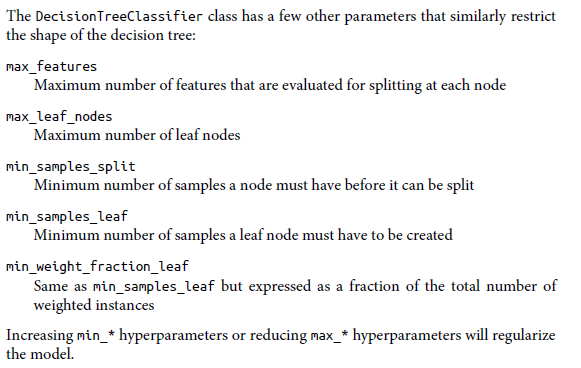

Algunos algoritmos funcionan primero entrenando el arbol sin restricción  y luego podando los nodos innecesarios. Se hace una prueba chi cuadrado para detectar las hojas innecesarias.

Un ejemplo de regularización:

In [8]:
from sklearn.datasets import make_moons

X_moons, y_moons = make_moons(n_samples = 150, noise = 0.2, random_state = 42)

tree_clf1 = DecisionTreeClassifier(random_state = 42)
tree_clf2 = DecisionTreeClassifier(min_samples_leaf = 5, random_state = 42)
tree_clf1.fit(X_moons, y_moons)
tree_clf2.fit(X_moons, y_moons)

DecisionTreeClassifier(min_samples_leaf=5, random_state=42)

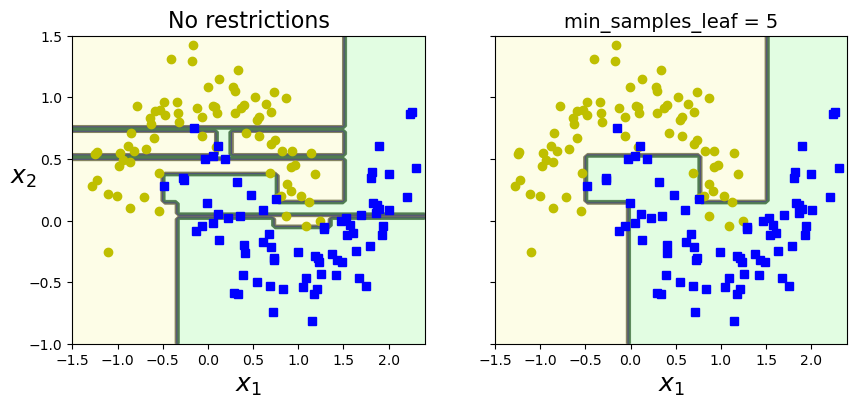

In [9]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf1, X_moons, y_moons, axes=[-1.5, 2.4, -1, 1.5], iris=False)
plt.title("No restrictions", fontsize=16)
plt.sca(axes[1])
plot_decision_boundary(tree_clf2, X_moons, y_moons, axes=[-1.5, 2.4, -1, 1.5], iris=False)
plt.title("min_samples_leaf = {}".format(tree_clf2.min_samples_leaf), fontsize=14)
plt.ylabel("")

plt.show()

El modelo a la izquierda está sobreajustando claramente, el de la derecha se espera que generalice mejor, vamos a probarlo

In [10]:
X_moons_test, y_moons_test = make_moons(n_samples=1000, noise=0.2, random_state=43)

print(tree_clf1.score(X_moons_test, y_moons_test))

tree_clf2.score(X_moons_test, y_moons_test)

0.898


0.92

## Regresión

Con árboles de decisión también se puede hacer regresión, aquí un ejemplo

In [11]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor

np.random.seed(42)
X_quad = np.random.rand(200, 1) - 0.5 # a single random input feature
y_quad = X_quad ** 2 + 0.025 * np.random.randn(200, 1)

tree_reg = DecisionTreeRegressor(max_depth = 2, random_state = 42)
tree_reg.fit(X_quad, y_quad)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [12]:
export_graphviz(
    tree_reg,
    out_file = 'tree_reg.dot',
    rounded = True,
    filled = True
)

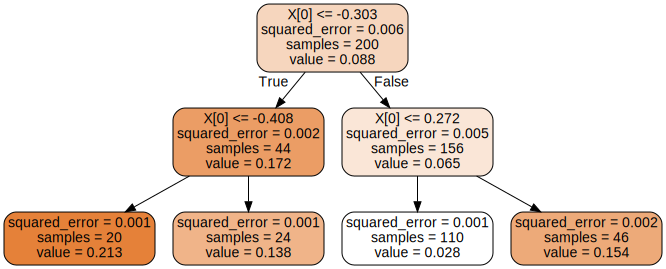

In [13]:
Source.from_file('tree_reg.dot')

Se ve muy parecido al de clasificación pero en vez de predecir una clase predice un valor, esta predicción es la media de las muestras en la clase.

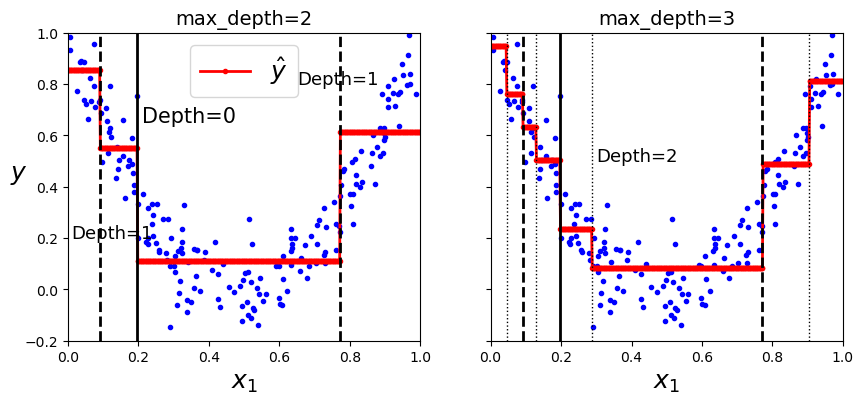

In [14]:
np.random.seed(42)
m = 200
X = np.random.rand(m, 1)
y = 4 * (X - 0.5) ** 2
y = y + np.random.randn(m, 1) / 10

tree_reg1 = DecisionTreeRegressor(random_state=42, max_depth=2)
tree_reg2 = DecisionTreeRegressor(random_state=42, max_depth=3)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

def plot_regression_predictions(tree_reg, X, y, axes=[0, 1, -0.2, 1], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)
    plt.plot(X, y, "b.")
    plt.plot(x1, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_regression_predictions(tree_reg1, X, y)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
plt.text(0.21, 0.65, "Depth=0", fontsize=15)
plt.text(0.01, 0.2, "Depth=1", fontsize=13)
plt.text(0.65, 0.8, "Depth=1", fontsize=13)
plt.legend(loc="upper center", fontsize=18)
plt.title("max_depth=2", fontsize=14)

plt.sca(axes[1])
plot_regression_predictions(tree_reg2, X, y, ylabel=None)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
for split in (0.0458, 0.1298, 0.2873, 0.9040):
    plt.plot([split, split], [-0.2, 1], "k:", linewidth=1)
plt.text(0.3, 0.5, "Depth=2", fontsize=13)
plt.title("max_depth=3", fontsize=14)

plt.show()

Con la profundidad máxima se puede mejorar las predicciones pero también corre el riesgo de sobre ajustar.

Para regresiones el algoritmo funciona igual pero en lugar de minimizar las impurezas minimiza el MSE.

$J\left(k, t_k\right)=\frac{m_{\text {left }}}{m} \mathrm{MSE}_{\text {left }}+\frac{m_{\text {right }}}{m} \mathrm{MSE}_{\text {right }} \quad$ where $\left\{\begin{array}{c}\operatorname{MSE}_{\text {node }}=\frac{\sum_{i \in \text { node }}\left(\hat{y}_{\text {node }}-y^{(i)}\right)^2}{m_{\text {node }}} \\ \hat{y}_{\text {node }}=\frac{\sum_{i \in \text { node }} y^{(i)}}{m_{\text {node }}}\end{array}\right.$

Para regresión también tienden a sobreajustar sin regularización, por ejemplo en la gráfica a conitnuación solo con establecer `min_samples_leaf = 10` mejora el modelo.

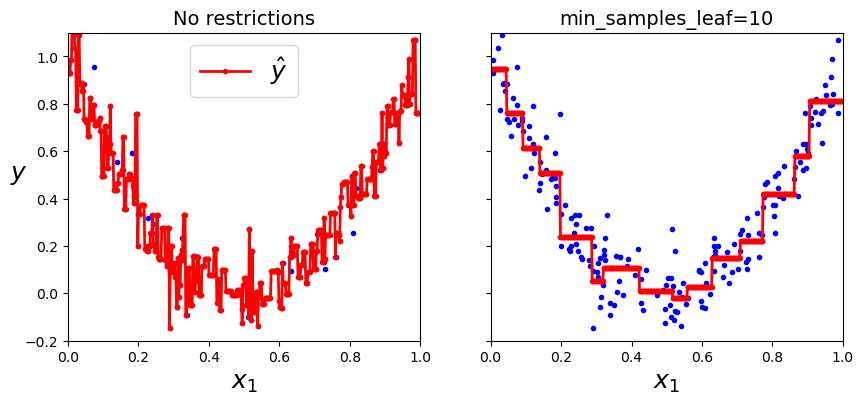

In [15]:
tree_reg1 = DecisionTreeRegressor(random_state=42)
tree_reg2 = DecisionTreeRegressor(random_state=42, min_samples_leaf=10)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

x1 = np.linspace(0, 1, 500).reshape(-1, 1)
y_pred1 = tree_reg1.predict(x1)
y_pred2 = tree_reg2.predict(x1)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(axes[0])
plt.plot(X, y, "b.")
plt.plot(x1, y_pred1, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", fontsize=18, rotation=0)
plt.legend(loc="upper center", fontsize=18)
plt.title("No restrictions", fontsize=14)

plt.sca(axes[1])
plt.plot(X, y, "b.")
plt.plot(x1, y_pred2, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.title("min_samples_leaf={}".format(tree_reg2.min_samples_leaf), fontsize=14)

plt.show()

## Sensible a la orientación del eje

Los árboles de decisión prefieren los limites de decisión ortogonales (todos las divisiones son perpendiculares a un eje), por lo tanto son sensibles a la orientación de los datos.

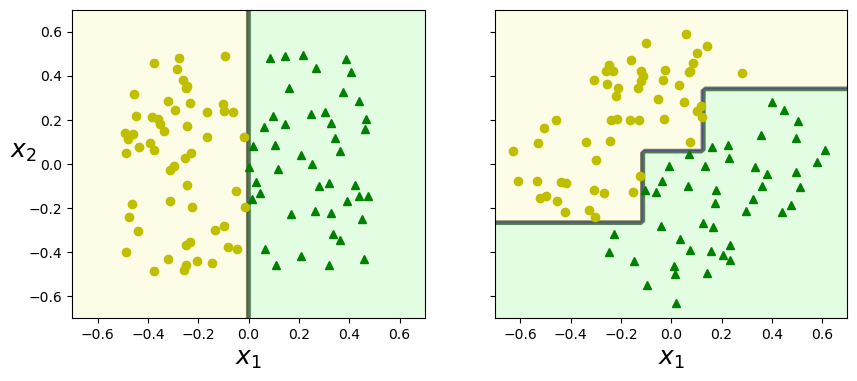

In [16]:
np.random.seed(6)
Xs = np.random.rand(100, 2) - 0.5
ys = (Xs[:, 0] > 0).astype(np.float32) * 2

angle = np.pi / 4
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
Xsr = Xs.dot(rotation_matrix)

tree_clf_s = DecisionTreeClassifier(random_state=42)
tree_clf_s.fit(Xs, ys)
tree_clf_sr = DecisionTreeClassifier(random_state=42)
tree_clf_sr.fit(Xsr, ys)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf_s, Xs, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)
plt.sca(axes[1])
plot_decision_boundary(tree_clf_sr, Xsr, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)
plt.ylabel("")

plt.show()

A la izquierda hay unos datos linearmente separables, si se rotan 45 grados el modelo igualmente los separa bien pero es posible que no generalice bien.

Una forma de solucionar esto es escalar los datos, a veces hace el modelo más facil. 

In [17]:
iris = load_iris(as_frame = True)
X_iris = iris.data[['petal length (cm)', 'petal width (cm)']].values
y_iris = iris.target

In [18]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pca_pipeline = make_pipeline(StandardScaler(), 
                            PCA())
X_iris_rotated = pca_pipeline.fit_transform(X_iris)
tree_clf_pca = DecisionTreeClassifier(max_depth = 2, random_state = 42)
tree_clf_pca.fit(X_iris_rotated, y_iris)

DecisionTreeClassifier(max_depth=2, random_state=42)

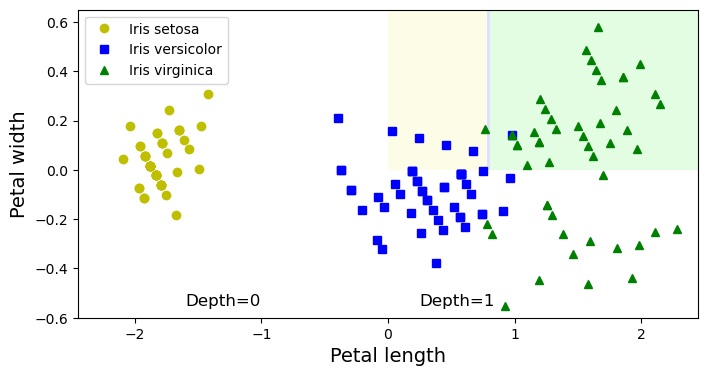

In [19]:
plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf_pca, X_iris_rotated, y_iris, legend=True)
plt.ylim([-0.6, 0.65])
plt.xlim([-2.45, 2.45])
plt.plot([0, 7.5], [0.8, 0.8], "k-", linewidth=2)
plt.plot([0, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.text(-1.6, -0.55, "Depth=0", fontsize=12)
plt.text(0.25, -0.55, "Depth=1", fontsize=12)
plt.legend(loc = 'best')
plt.show()

## Los arboles de decision tienen varianza alta

El principal problema con los arboles de decisión es que tienen una varianza alta, cambios pequeños en los hiperparametros producen modelos muy diferentes. 

Al promediar la predicción de muchos arboles es posible reducir la varianza mucho, esto se llama `Random Forest` y es de los modelos más poderosos.

## Ejercicios

1. What is the approximate depth of a decision tree trained (without restrictions) on a training set with one million instances?

Sin restricciones el el árbol con m hojas contiene $log_2(m)$, lo cual es igual a $log(m)/log(2)$, por lo tanto, si er arbol tiene 1 millon de observaciones va a tener una profundida de $log_2(10^6) \approx 20$.

2. Is a node’s Gini impurity generally lower or higher than its parent’s? Is it generally lower/higher, or always lower/higher?

Generalmente más bajo ya que los la función de costo de CART divide cada nodo minimizando la suma ponderada de la impureza de gini de sus hijos. Sin embargo es posible que impureza sea mayor siempre que el incremento sea mas que compensado por la disminución de la impureza del otro hijo.

3. If a decision tree is overfitting the training set, is it a good idea to try decreasing max_depth?

Si, al haber sobreajuste y disminuir la profundidad el modelo va a generalizar más, más observaciones van a estar en cada hoja, por lo tanto más sesgo pero menos varianza.

4. If a decision tree is underfitting the training set, is it a good idea to try scaling the input features?

No, los árboles de decisión no necesitan escalar las variables, si se está subajustando escalar las variables solo va a ser una perdida de tiempo.

5. If it takes one hour to train a decision tree on a training set containing one million instances, roughly how much time will it take to train another decision tree on a training set containing ten million instances? Hint: consider the CART algorithm’s computational complexity.

La complejidad computacional es igual a $K = (n \times m \times \log_2(m)) / (n \times m \times \log_2(10m))$, si $m = 10^6$ entonces $K \approx 11.7$.

6. If it takes one hour to train a decision tree on a given training set, roughly how much time will it take if you double the number of features?

Aproximadamente el doble.

7. Train and fine-tune a decision tree for the moons dataset by following these steps:

    a. Use make_moons(n_samples=10000, noise=0.4) to generate a moons dataset.

In [22]:
X_moons, y_moons = make_moons(n_samples = 10000, noise = 0.4)

    b. Use train_test_split() to split the dataset into a training set and a test set.

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_moons, y_moons, test_size = 0.2, random_state = 42)

    c. Use grid search with cross-validation (with the help of the GridSearchCV class) to find good hyperparameter values  for a DecisionTreeClassifier. Hint: try various values for max_leaf_nodes.

In [27]:
from sklearn.model_selection import GridSearchCV

params = {
    'max_leaf_nodes': list(range(2, 100)),
    'max_depth': list(range(1, 7)),
    'min_samples_split': [2, 3, 4]
}


grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state = 42),
                             params,
                             cv = 3)

grid_search_cv.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6],
                         'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                            13, 14, 15, 16, 17, 18, 19, 20, 21,
                                            22, 23, 24, 25, 26, 27, 28, 29, 30,
                                            31, ...],
                         'min_samples_split': [2, 3, 4]})

In [28]:
grid_search_cv.best_estimator_

DecisionTreeClassifier(max_depth=2, max_leaf_nodes=4, random_state=42)

    d. Train it on the full training set using these hyperparameters, and measure your model's performance on the test set. You should get roughly 85% to 87% accuracy.
        
Por default `GridSearchCv` entrena el mejor modelo encontrado en todo el conjunto de entrenamiento.

In [30]:
from sklearn.metrics import accuracy_score 

y_pred = grid_search_cv.predict(X_test)
accuracy_score(y_test, y_pred)

0.8595

8. Grow a forest by following these steps:
    
    a. Continuing the previous exercise, generate 1,000 subsets of the training set,
    each containing 100 instances selected randomly. Hint: you can use Scikit-
    Learn’s ShuffleSplit class for this.

In [34]:
from sklearn.model_selection import ShuffleSplit

n_trees = 1000
n_instances = 100

mini_sets = []

rs = ShuffleSplit(n_splits=n_trees, test_size=len(X_train) - n_instances,
                  random_state=42)

for mini_train_index, mini_test_index in rs.split(X_train):
    X_mini_train = X_train[mini_train_index]
    y_mini_train = y_train[mini_train_index]
    mini_sets.append((X_mini_train, y_mini_train))

    b. Train one Decision Tree on each subset, using the best hyperparameter values found above. Evaluate these 1,000 Decision Trees on the test set. Since they were trained on smaller sets, these Decision Trees will likely perform worse than the first Decision Tree, achieving only about 80% accuracy.

In [35]:
from sklearn.base import clone

forest = [clone(grid_search_cv.best_estimator_) for _ in range(n_trees)]

accuracy_scores = []

for tree, (X_mini_train, y_mini_train) in zip(forest, mini_sets):
    tree.fit(X_mini_train, y_mini_train)
    
    y_pred = tree.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))

np.mean(accuracy_scores)

0.820457

    c. Now comes the magic. For each test set instance, generate the predictions of the 1,000 Decision Trees, and keep only the most frequent prediction (you can use SciPy's mode() function for this). This gives you majority-vote predictions over the test set.

In [36]:
Y_pred = np.empty([n_trees, len(X_test)], dtype = np.uint8)

for tree_index, tree in enumerate(forest):
    Y_pred[tree_index] = tree.predict(X_test)

In [38]:
from scipy.stats import mode

y_pred_majority_votes, n_votes = mode(Y_pred, axis = 0, keepdims = True)

    d. Evaluate these predictions on the test set: you should obtain a slightly higher accuracy than your first model (about 0.5 to 1.5% higher). Congratulations, you have trained a Random Forest classifier!

In [39]:
accuracy_score(y_test, y_pred_majority_votes.reshape([-1]))

0.858